# Get data from google drive

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/databardl/bargraphs"))

# Any results you write to the current directory are saved as output.


['abar_vertical_stacked', 'cvertical_bargraph', 'bar_horizontal_stacked', 'horizontal_bargraph']


In [2]:
######## Gpu Check ###########
import tensorflow as tf 
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':  
    raise SystemError('GPU device not found') 
print('Found GPU at: {}'.format(device_name)) 

Found GPU at: /device:GPU:0


In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

# Get data from zip file

In [4]:
# import zipfile
# zip_ref = zipfile.ZipFile('../input/data/natural_images', 'r')
# zip_ref.extractall()
# zip_ref.close()

In [5]:
from os import listdir
img_dir = '../input/databardl/bargraphs'
data_list = listdir(img_dir)
data_list

['abar_vertical_stacked',
 'cvertical_bargraph',
 'bar_horizontal_stacked',
 'horizontal_bargraph']

# Resnet

## Image process and variable declare

In [6]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf


DATASET_PATH  = img_dir
IMAGE_SIZE    = (400, 400)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 25  
FREEZE_LAYERS = 16  
NUM_EPOCHS    = 10
LEARNING_RATE = 5e-5
DROP_OUT = .5
chkpoint_model_loc = '5'


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=0,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.25,
                                   zoom_range=0.1,
                                   channel_shift_range = 20,
                                   horizontal_flip = False ,
                                   vertical_flip = False ,
                                   validation_split = 0.2,
                                   fill_mode='constant')

# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                    fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "training"
                                                  )

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,
                                                  target_size=IMAGE_SIZE,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  subset = "validation"
                                                  )
class_dictionary = train_batches.class_indices
class_dictionary


Found 12800 images belonging to 4 classes.
Found 3200 images belonging to 4 classes.


{'abar_vertical_stacked': 0,
 'bar_horizontal_stacked': 1,
 'cvertical_bargraph': 2,
 'horizontal_bargraph': 3}

In [7]:
len(chkpoint_model_loc)

1

## Layer modification

In [8]:
# build our classifier model based on pre-trained InceptionResNetV2:
# 1. we don't include the top (fully connected) layers of InceptionResNetV2
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
from tensorflow.keras.layers import GlobalAveragePooling2D
if len(chkpoint_model_loc) < 5:
#############main portion for InceptionResnetV2 only##############
  net = InceptionResNetV2(include_top=False,
                          weights='imagenet',
                          input_tensor=None,
                          input_shape=(299,299,3))

  ############## Run this block if include top = False ######
  x = net.output
  x = GlobalAveragePooling2D()(x)
#   x = Flatten()(x)
#   x = Dropout(DROP_OUT)(x)
###############   End of block ##################

############## Run this block if include top = True ######
#   '''
#   This block keeps avg_pool (GlobalAveragePooling2) layer and removes only prediction layer.
#   Then replace inceptionResnetv2's predictionlayer with a drpout layer and and a softmax layer. 
#   To change the class class size of 1000 to 8 we need to replace their pediction layer with our softmax layer.
#   '''
#   avg_pool = net.layers[-2]
#   prediction = net.layers[-1]

#   #create drpout layer
#   drp1 = Dropout(DROP_OUT)
#   x = drp1(avg_pool.output)
###############   End of block ##################



  output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
  net_final = Model(inputs=net.input, outputs=output_layer)

  for layer in net_final.layers[:FREEZE_LAYERS]:
      layer.trainable = False

  for layer in net_final.layers[FREEZE_LAYERS:]:
      layer.trainable = True

  net_final.compile(optimizer=Adam(lr=LEARNING_RATE),
                    loss='categorical_crossentropy', metrics=['accuracy'])

#   print(net_final.summary())

Instructions for updating:
Colocations handled automatically by placer.
219062272/219055592 [==============================] - 3s 0us/step


In [9]:
from keras import applications
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle

from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(400,400,3))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(4, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool

In [10]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

## Checkpoint declare

In [11]:
#CHECKPOINT
# filepath = "../weights-improvement-EPOCH_{epoch:02d}-ACC_{acc:.2f}-VALIDATION_{val_acc:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# load pretrained model

In [12]:
######## if running pre trained model is running #######
# if len(chkpoint_model_loc) > 5:
#   net_final = load_model(chkpoint_model_loc)
#   net_final.evaluate_generator(valid_batches,
#                                steps = np.ceil(len(valid_batches) / BATCH_SIZE),
#                                verbose = 1
#                                )


## Evaluation of loaded model

In [13]:
if len(chkpoint_model_loc) > 5:
    
    model.evaluate_generator(valid_batches,
                               steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                               verbose = 1
                               )


# DropOut add

In [14]:
#Adding Dropout layer to a pre trained model
drpout_needed = False

if drpout_needed :
  flt = net_final.layers[-2]
  prediction = net_final.layers[-1]

  #create drpout layer
  drp1 = Dropout(DROP_OUT)
  x = drp1(flt.output)

  predictors = prediction(x)
  net_final = Model(inputs=net_final.input, outputs=predictors)

# Summary

In [15]:
print(net_final.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [16]:
# !pip install tensorflow-gpu==2.0.0-alpha0
# import tensorflow as tf
# print(tf.__version__)

In [17]:
model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
    epochs= 10,
    validation_data = valid_batches,
    callbacks=[ModelCheckpoint('VGG19-transferlearning.model', monitor='val_acc')]
)

NameError: name 'x_train' is not defined

# Run Training

In [18]:

#FIT MODEL
model.fit_generator(train_batches,
                        steps_per_epoch = np.ceil(len(train_batches) / BATCH_SIZE),
                        validation_data = valid_batches,
                        validation_steps = np.ceil(len(valid_batches) / BATCH_SIZE),
                        epochs = NUM_EPOCHS,
#                       callbacks=[ModelCheckpoint('VGG19-transferlearning.model', monitor='val_acc')] 
                       )


Instructions for updating:
Use tf.cast instead.
Epoch 1/10
21/21 [==============================] - 40s 2s/step - loss: 0.5659 - acc: 0.7486 - val_loss: 0.5258 - val_acc: 0.7483
Epoch 2/10
21/21 [==============================] - 30s 1s/step - loss: 0.4640 - acc: 0.7595 - val_loss: 0.4233 - val_acc: 0.7883
Epoch 3/10
21/21 [==============================] - 30s 1s/step - loss: 0.3922 - acc: 0.7967 - val_loss: 0.3977 - val_acc: 0.7783
Epoch 4/10
21/21 [==============================] - 30s 1s/step - loss: 0.3248 - acc: 0.8367 - val_loss: 0.2560 - val_acc: 0.8983
Epoch 5/10
21/21 [==============================] - 30s 1s/step - loss: 0.2599 - acc: 0.8900 - val_loss: 0.2246 - val_acc: 0.9200
Epoch 6/10
21/21 [==============================] - 30s 1s/step - loss: 0.1862 - acc: 0.9457 - val_loss: 0.1214 - val_acc: 0.9883
Epoch 7/10
21/21 [==============================] - 30s 1s/step - loss: 0.1172 - acc: 0.9719 - val_loss: 0.0763 - val_acc: 0.9917
Epoch 8/10
21/21 [========================

In [19]:
# # save trained weights
# # net_final.save(WEIGHTS_FINAL)
# x = net_final.evaluate_generator(valid_batches,
#                            steps = np.ceil(len(valid_batches) / BATCH_SIZE),
#                            use_multiprocessing = True,
#                            verbose = 1
#                            )

In [20]:
# incorrects = np.nonzero(net_final.predict(valid_batches).reshape((-1,)) != valid_batches)

# Predict

In [21]:
model56=model.save("bargraph_classifier_10epoch_vgg19.h5")

In [22]:
#model=tf.keras.models.load_model("../input/barplot-classification/bargraph_classifier_vgg16.h5")

Class name to class id map
 {'abar_vertical_stacked': 0, 'bar_horizontal_stacked': 1, 'cvertical_bargraph': 2, 'horizontal_bargraph': 3}
       pred
0  0.998828
1  0.000999
2  0.000169
3  0.000004
Class prediction =  abar_vertical_stacked


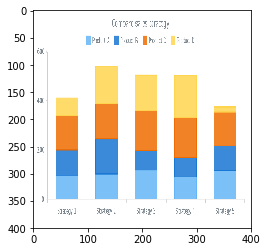

In [23]:
# from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

IMAGE_SIZE    = (400, 400)
# print(data_list)
print("Class name to class id map\n",class_dictionary)

#test_image = image.load_img((img_dir + "/motorbike/motorbike_0011.jpg"),target_size =IMAGE_SIZE )
test_image = image.load_img("../input/supertest/5-stacked-bar-chart-large-opt.png",target_size =IMAGE_SIZE )
test_image = image.img_to_array(test_image)

plt.imshow(test_image/255.)

# test_image = np.expand_dims(test_image , axis = 0)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
test_image = preprocess_input(test_image)

prediction = model.predict(test_image)
df = pd.DataFrame({'pred':prediction[0]})
# print(prediction[0])
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(df)

for x in data_list:
    if class_dictionary[x] == (df[df == df.iloc[0]].index[0]):
        print("Class prediction = ", x)
        break

** pascale voc dataset
**

https://github.com/makatx/YOLO_ResNet/blob/master/Vehicle%20Detection.ipynb
https://github.com/makatx/YOLO_ResNet/blob/master/Dataset%20Exploration.ipynb


https://www.kaggle.com/zaraks/pascal-voc-2007/kernels
https://www.kaggle.com/huanghanchina/pascal-voc-2012/kernels

In [24]:

# import sys
# import numpy as np
# import cv2
# import utils
# import matplotlib.pyplot as plt


# pred = net_final.predict(test_image)

# bboxes = utils.get_boxes(pred[0], cutoff=0.1)
# bboxes = utils.nonmax_suppression(bboxes, iou_cutoff = 0.05)
# draw = utils.draw_boxes(img, bboxes, color=(0, 0, 255), thick=3, draw_dot=True, radius=3)
# draw = draw.astype(np.uint8)

# plt.imshow(draw[...,::-1])
# plt.show()

In [25]:
# # from PIL import Image
# import pandas as pd
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt

# IMAGE_SIZE    = (299, 299)

# test_image = image.load_img("../input/data/natural_images/motorbike/motorbike_0000.jpg",target_size =IMAGE_SIZE )
# test_image = image.img_to_array(test_image)
# plt.imshow(test_image/255.)
# test_image = np.expand_dims(test_image , axis = 0)

# prediction = net_final.predict(test_image)
# df = pd.DataFrame({'pred':prediction[0]})
# print(prediction[0])
# df.sort_values(by='pred', ascending=False, na_position='first')